## Environment Set-up
The recommended operating environment is as follows:
| Package         | Version |
|-----------------|---------|
| CUDA            | 11.8    |
| Huggingface-Hub | 0.23.4  |
| nibabel         | 5.2.1   |
| Python          | 3.8.19  |
| PyTorch         | 2.2.1   |
| torchvision     | 0.17.2  |
| timm            | 0.9.16  |
| transformers    | 4.39.3  |


# Download Weight
Please download the weights from Baidu Netdisk and place them under "ckpt/".

Link：https://pan.baidu.com/s/1eCuHs3qhd1lyVGqUOdaeFw?pwd=r1pg 

Password：r1pg 


# IMISNet generates predicted object masks based on interaction

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import os
from PIL import Image

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

## Example image

In [2]:
image = Image.open('demo_image/train_177_51.png').convert('RGB') 
image = np.array(image)
image.shape

(512, 512, 3)

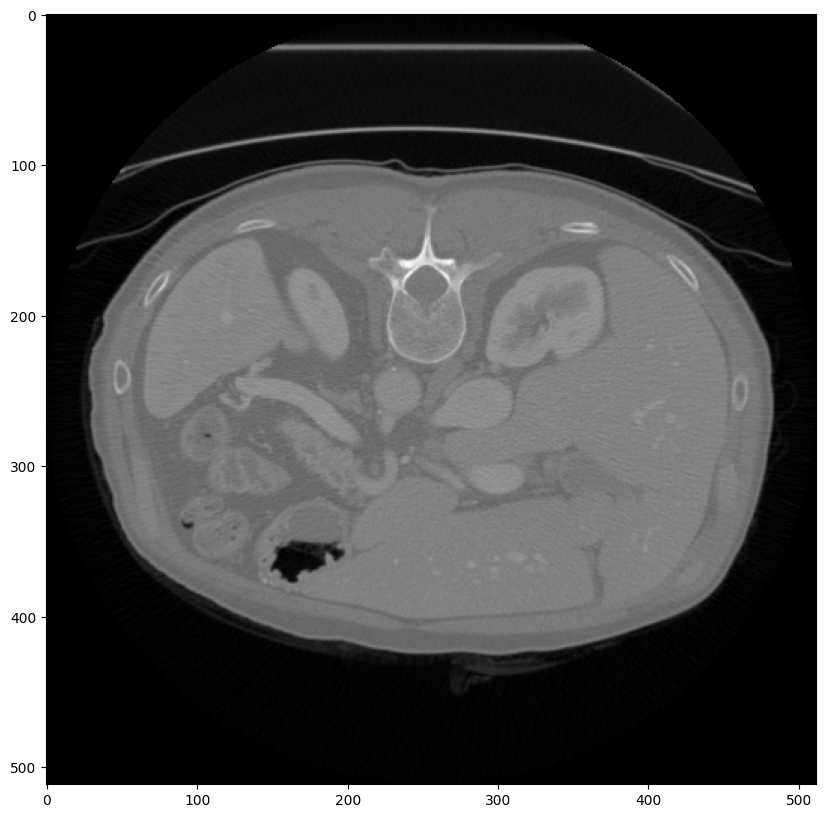

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

## Load IMIS Network

In [4]:
from segment_anything import sam_model_registry
from segment_anything.predictor import IMISPredictor
from argparse import Namespace
from model import IMISNet
import torch

args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 1024
args.sam_checkpoint = 'ckpt/IMISNet-B.pth'
category_weights = 'dataloaders/categories_weight.pkl'

sam = sam_model_registry["vit_b"](args).to(device)
imisnet = IMISNet(sam, test_mode=True, category_weights=category_weights).to(device)

predictor = IMISPredictor(imisnet)

******Loaded IMISNet parameters


Process the image to produce an image embedding by calling `SammedPredictor.set_image`. `SammedPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [5]:
import warnings
warnings.filterwarnings("ignore", message="1Torch was not compiled with flash attention.")

predictor.set_image(image)

## Click to interact with specific objects

### Click to segment the kidney

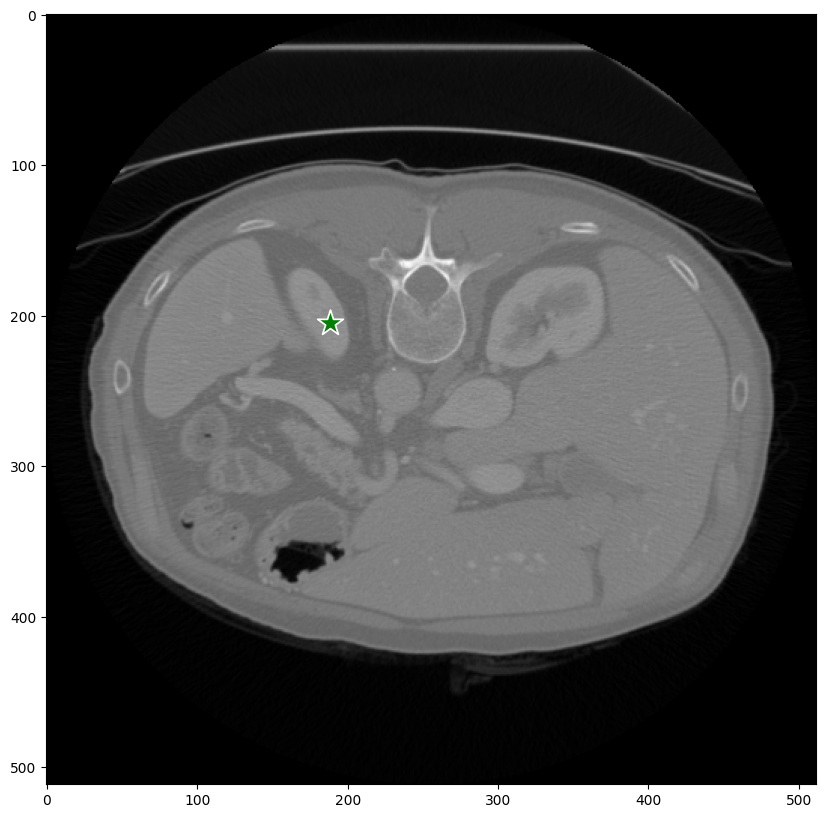

In [6]:
ori_h, ori_w, _ = image.shape
input_point = np.array([[188, 205]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

['kidney']


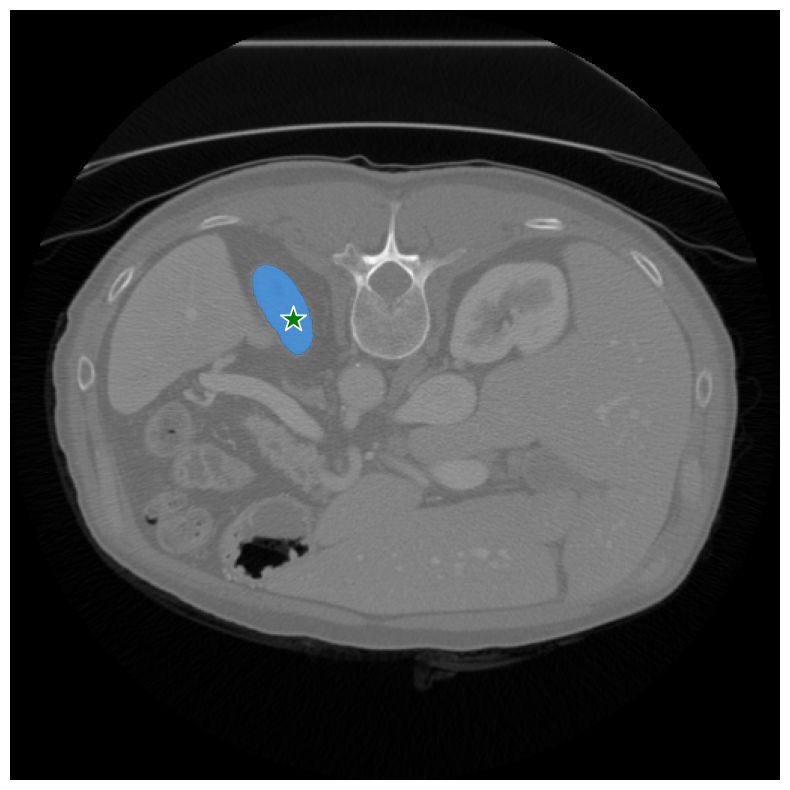

In [7]:
masks, logits, category_pred = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    text = None,
    multimask_output=False,
)

print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()


['kidney']


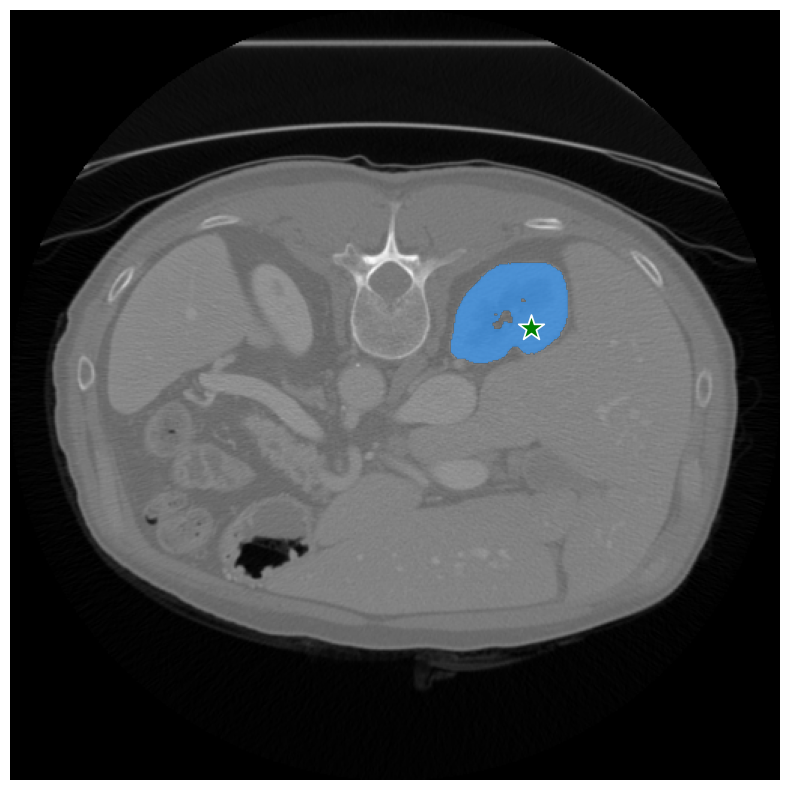

In [8]:
input_point = np.array([[346, 211]])
input_label = np.array([1])
masks, logits, category_pred = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=None,
    text = None,
    multimask_output=False,
)

print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

### Multiple click correction

['liver']


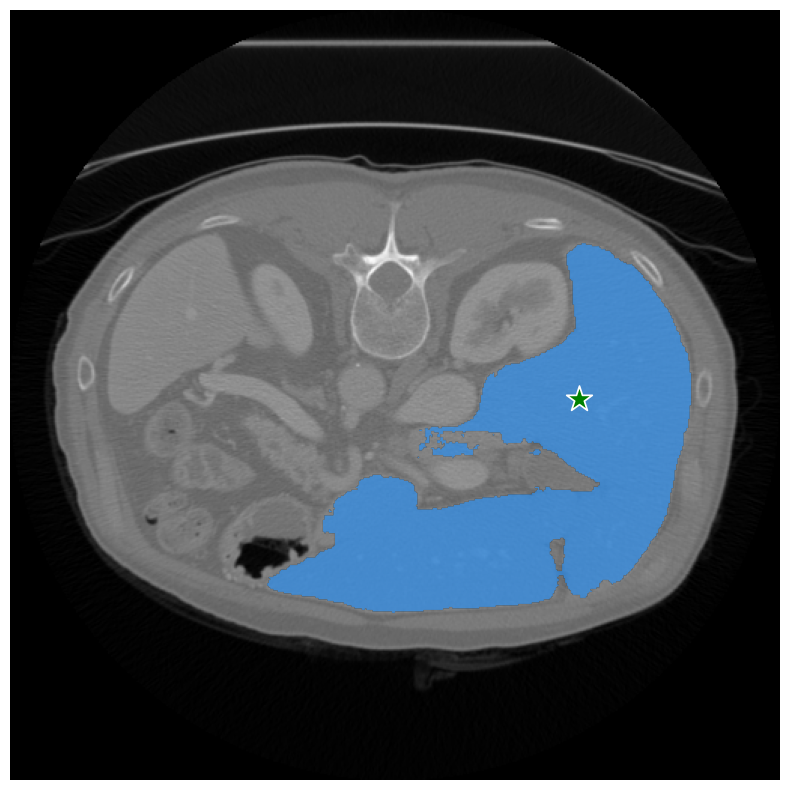

In [9]:
input_point = np.array([[378, 258]])
input_label = np.array([1])
masks, logits, category_pred = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=None,
    text = None,
    multimask_output=False,
)

print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

['liver']


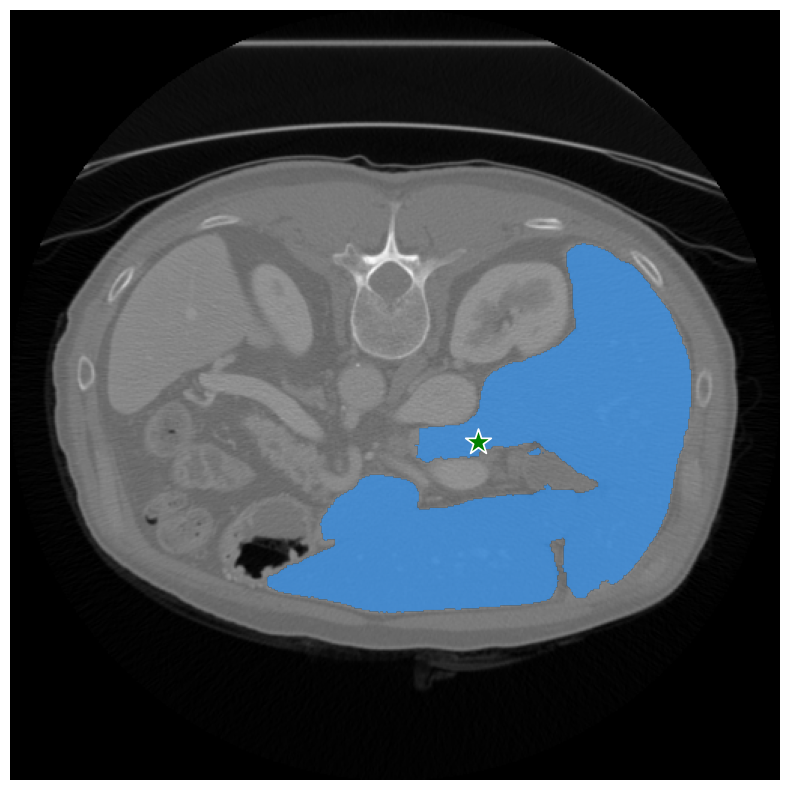

In [10]:
input_point = np.array([[311, 287]])
input_label = np.array([1])
masks, logits, category_pred = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=logits,
    text = None,
    multimask_output=False,
)

print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

### Bounding box interactive segmentation

['lumbar spine']


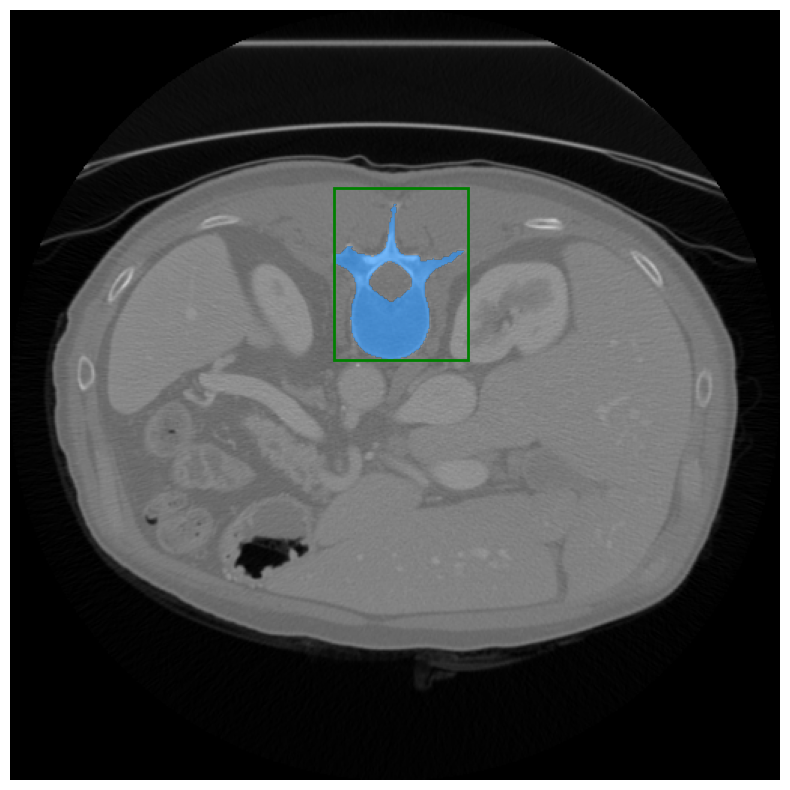

In [11]:
input_bbox = np.array([215, 118,304,232])
masks, logits, category_pred = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=None,
    box= input_bbox,
    text = None,
    multimask_output=False,
)

print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_box(input_bbox, plt.gca())
plt.axis('off')
plt.show()

['aorta']


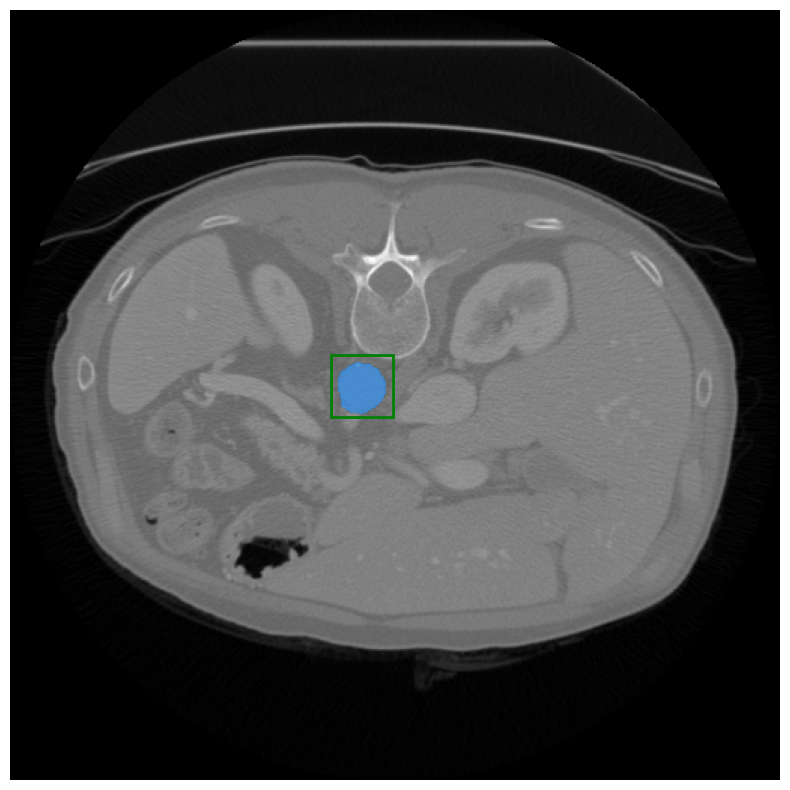

In [12]:
input_bbox = np.array([213, 229, 254, 270])
masks, logits, category_pred = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=None,
    box= input_bbox,
    text = None,
    multimask_output=False,
)

print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_box(input_bbox, plt.gca())
plt.axis('off')
plt.show()

### Text interaction generates segmentation results

['kidney']


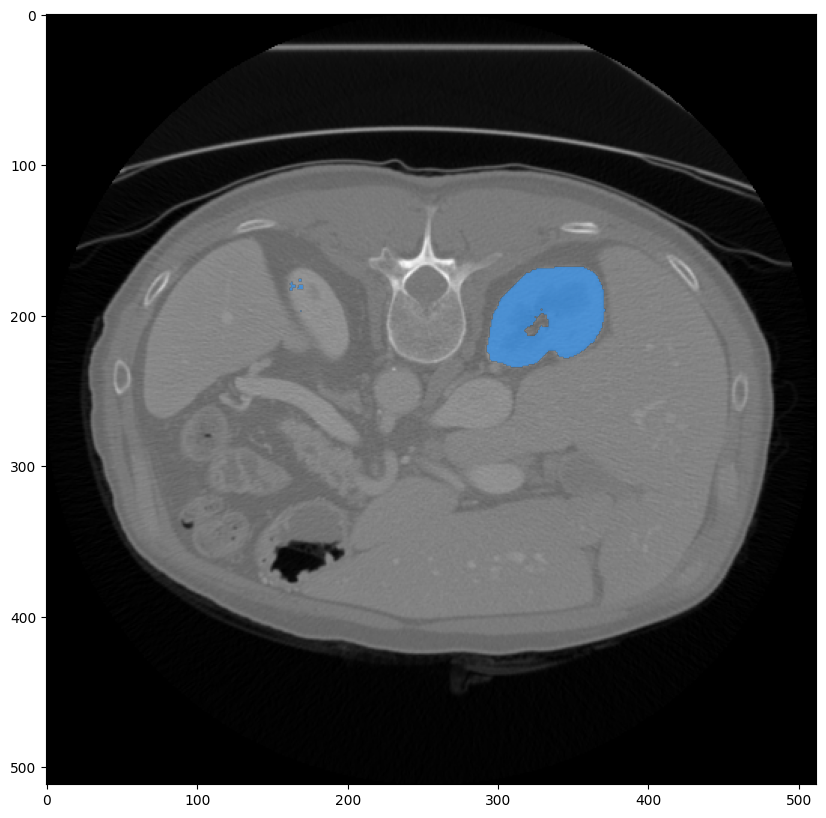

In [13]:
text = ['kidney_right']
masks, logits, category_pred = predictor.predict(
    point_coords=None,
    point_labels=None,
    box= None,
    text = text,
    multimask_output=False,
)
print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())


['kidney']


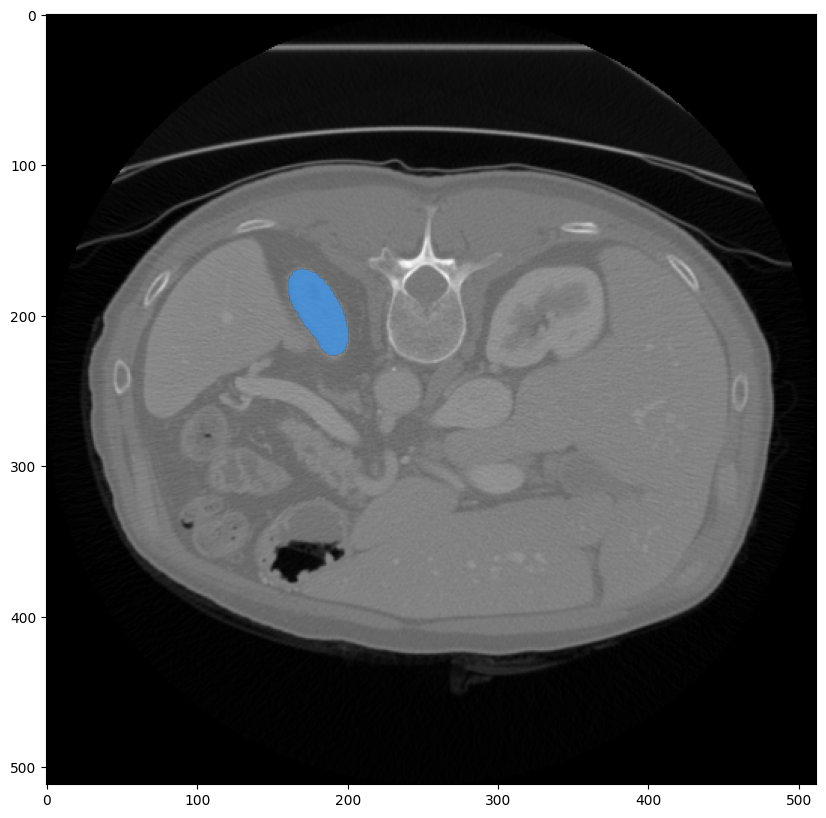

In [14]:
text = ['kidney_left']
masks, logits, category_pred = predictor.predict(
    point_coords=None,
    point_labels=None,
    box= None,
    text = text,
    multimask_output=False,
)
print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())

['liver']


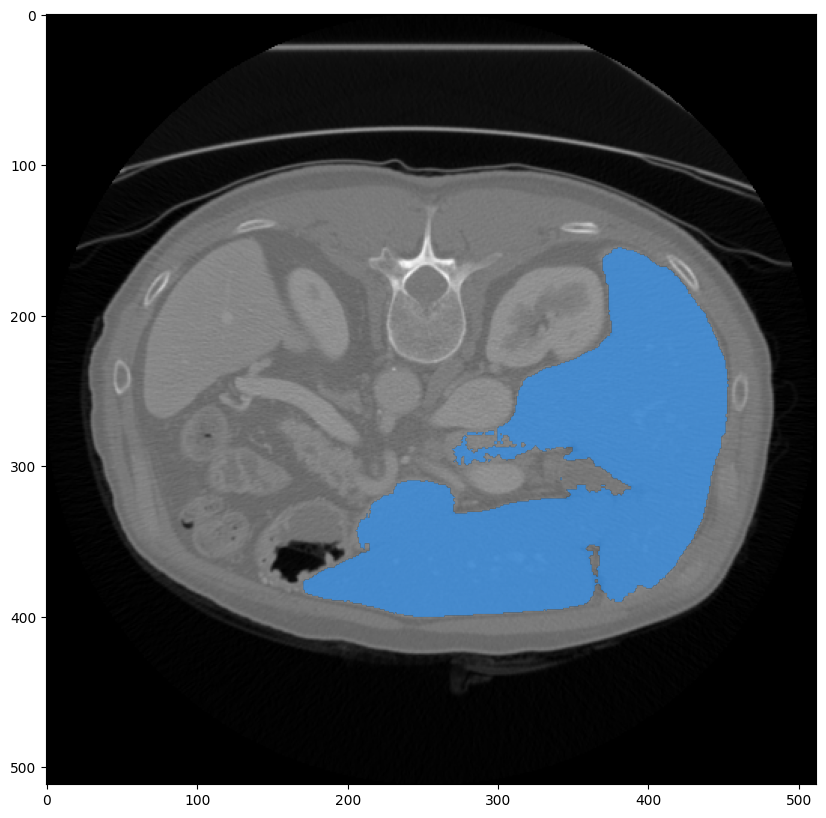

In [15]:
text = ['liver']
masks, logits, category_pred = predictor.predict(
    point_coords=None,
    point_labels=None,
    box= None,
    text = text,
    multimask_output=False,
)
print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())

['liver']


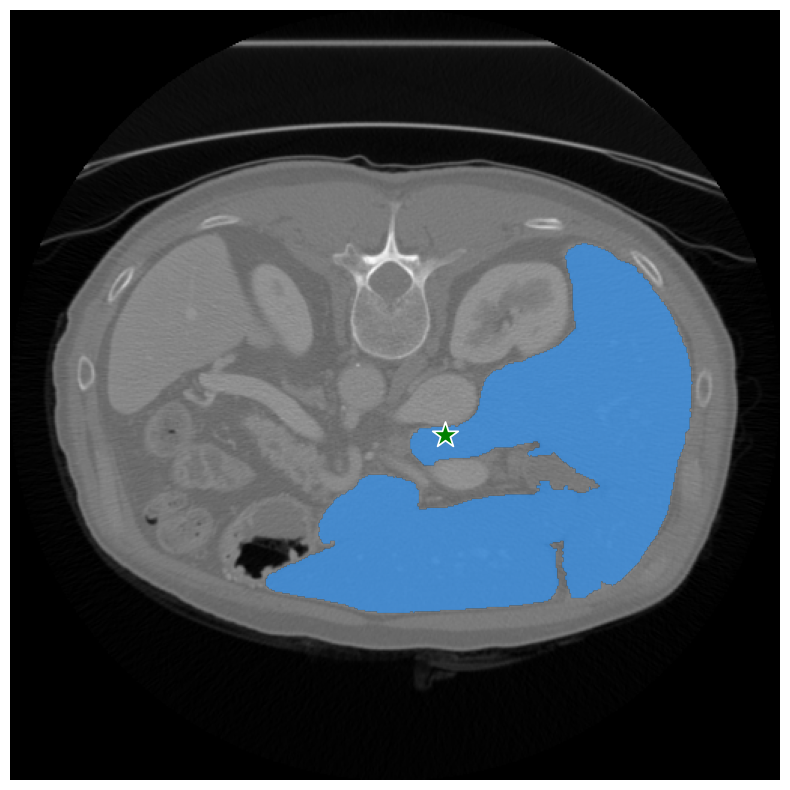

In [16]:
input_point = np.array([[289, 282]])
input_label = np.array([1])
masks, logits, category_pred = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=logits,
    text = text,
    multimask_output=False,
)

print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

(2, 1, 512, 512)


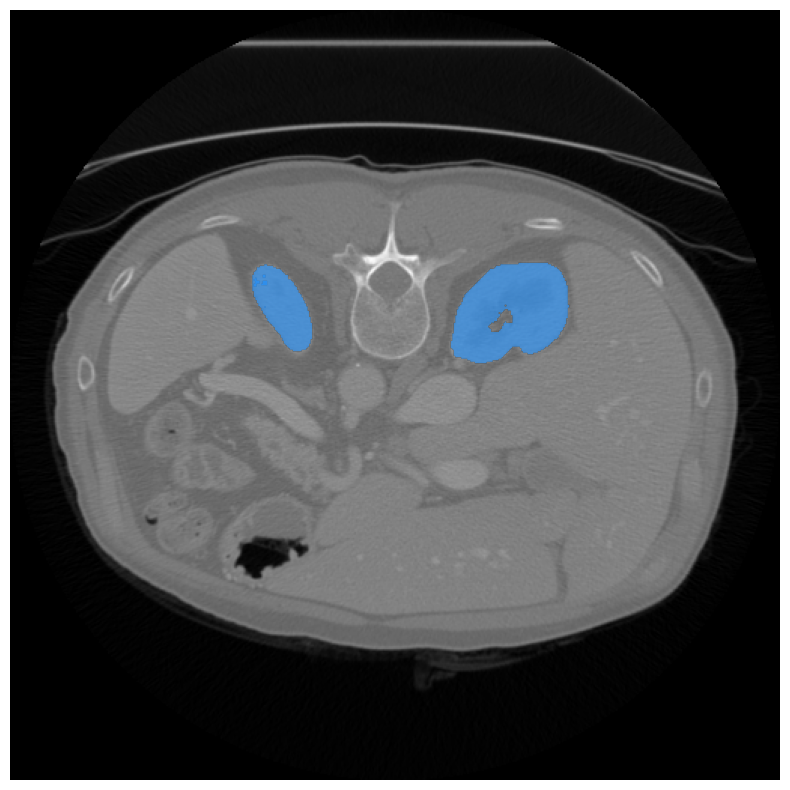

In [17]:
text_input = ['kidney_right', 'kidney_left']
masks_list = []
for text in text_input:
    masks, logits, category_pred = predictor.predict(
        point_coords=None,
        point_labels=None,
        box= None,
        text = [text],
        multimask_output=False,
    )
    masks.shape  # (number_of_masks) x H x W
    masks_list.append(masks)
masks = np.concatenate(masks_list, axis=0)
print(masks.shape)

plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca())
plt.axis('off')
plt.show()

## Optimizing Segmentation Results by Point Interaction

In [18]:
image = Image.open('demo_image/ABD_001_67.png').convert('RGB') 
image = np.array(image)
image.shape

(512, 512, 3)

In [19]:
predictor.set_image(image)

['spleen', 'colon', 'iliopsoas', 'lumbar spine']


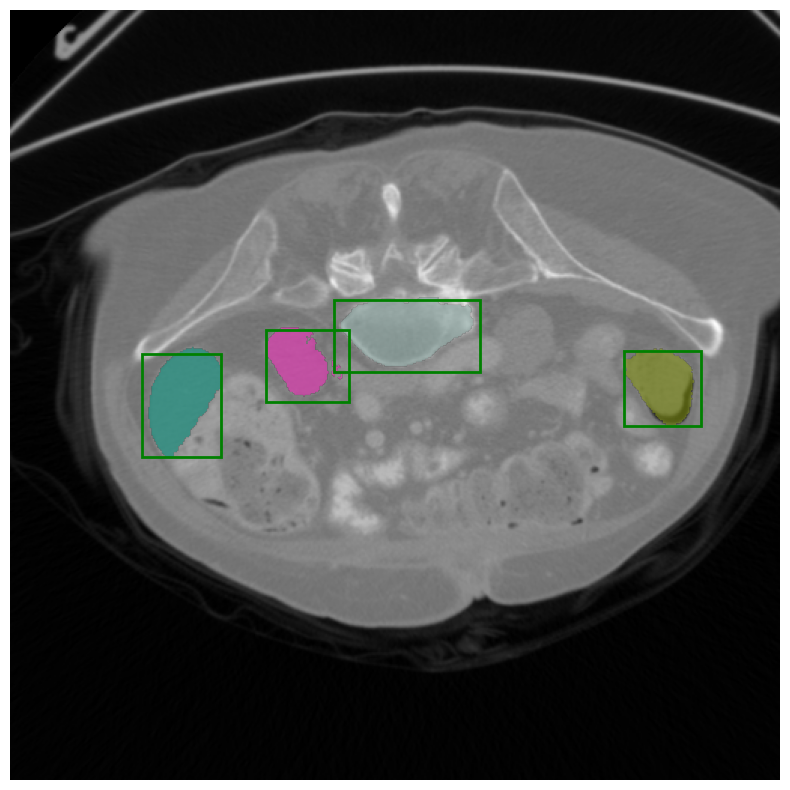

In [20]:
input_bbox = np.array([[87, 228, 140, 297],[408,226,459,276],[170,212,225,260],[215,192,312,240]])
masks, logits, category_pred = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input = None,
    box = input_bbox,
    multimask_output=False,
)
print(category_pred)
masks.shape  # (number_of_masks) x H x W

plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
for box in input_bbox:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [21]:
image = Image.open('demo_image/lung_005_160.png').convert('RGB') 
image = np.array(image)
image.shape

(512, 512, 3)

In [22]:
predictor.set_image(image)

['aorta']


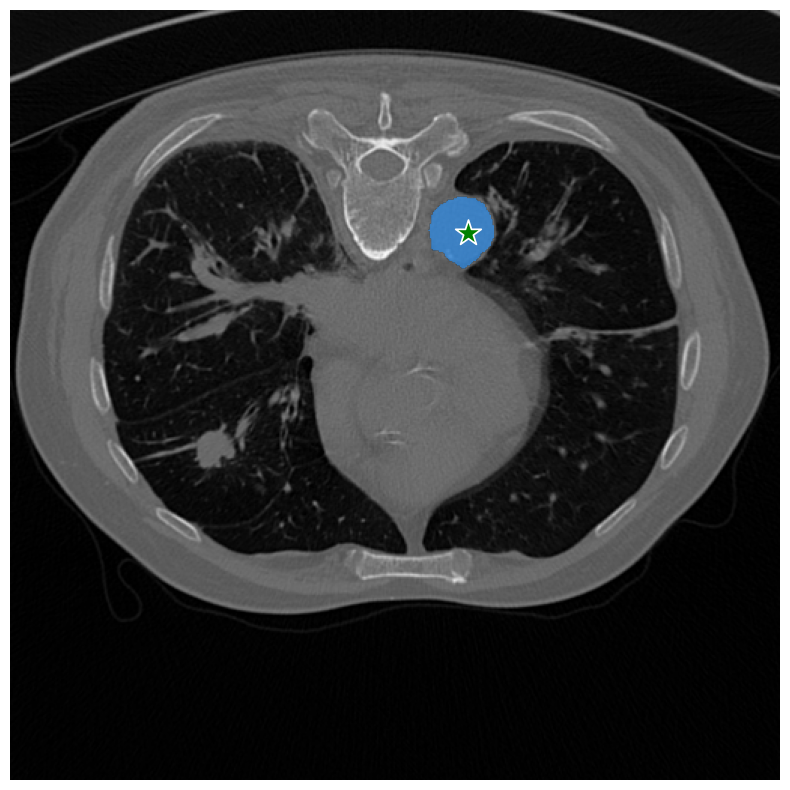

In [23]:
input_point = np.array([[304, 148]])
input_label = np.array([1])
masks, logits, category_pred = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=None,
    text = None,
    multimask_output=False,
)
print(category_pred)
masks.shape  # (number_of_masks) x H x W
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

['lung']


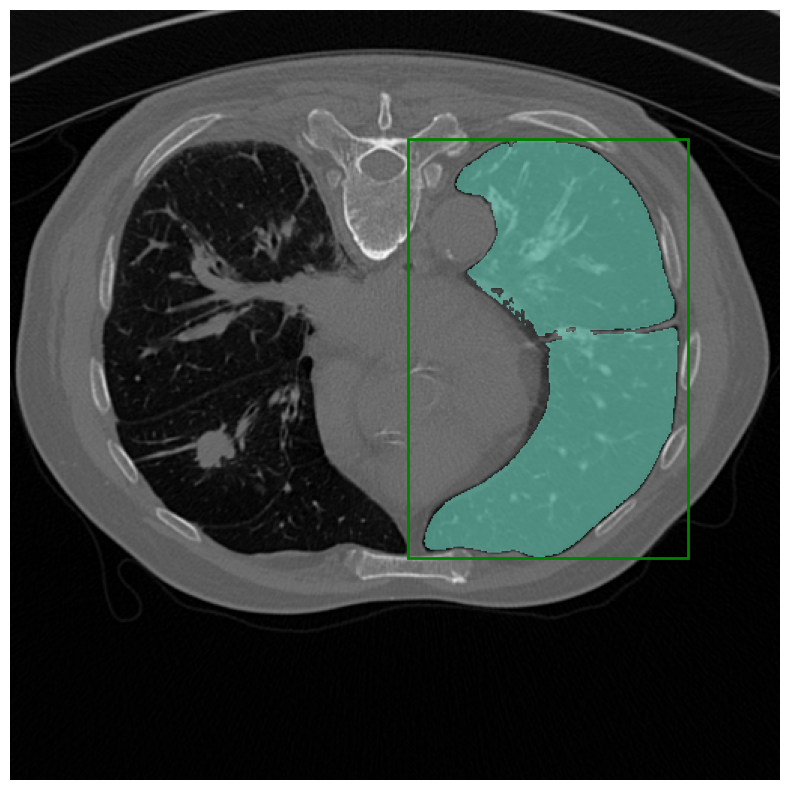

In [24]:
input_bbox = np.array([[264, 85, 450, 364]])
masks, logits, category_pred = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=None,
    text = None,
    box=input_bbox,
    multimask_output=False,
)
print(category_pred)

plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
for box in input_bbox:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

['lung']


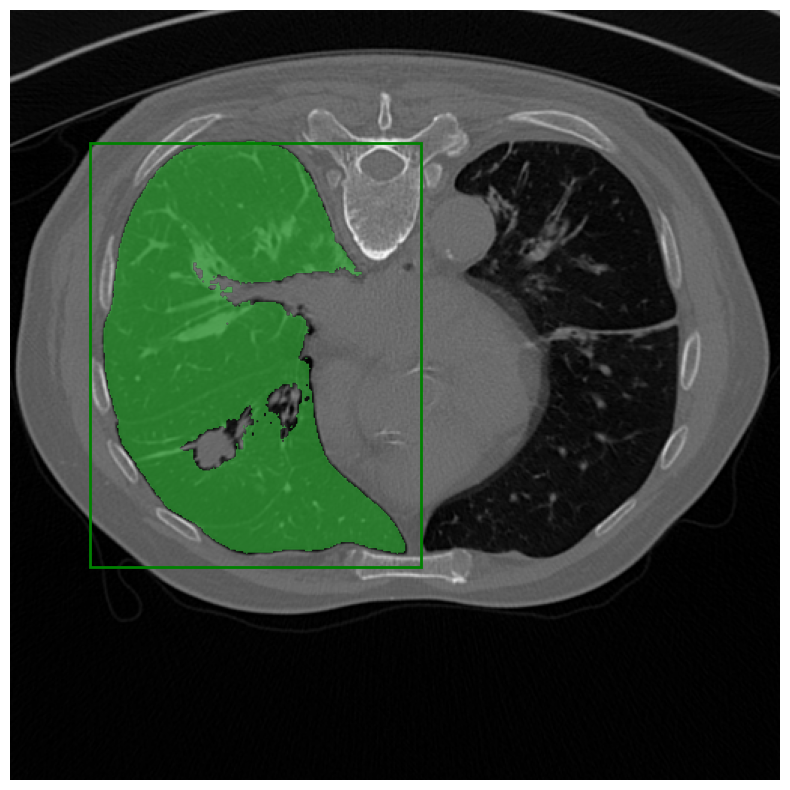

In [25]:
input_bbox = np.array([[53, 88, 273,370]])
masks, logits, category_pred = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=None,
    text = None,
    box=input_bbox,
    multimask_output=False,
)

print(category_pred)
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
for box in input_bbox:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [26]:
image = Image.open('demo_image/ISIC_0012092.jpg').convert('RGB') 
image = np.array(image)
image.shape
predictor.set_image(image)

['skin lesion']


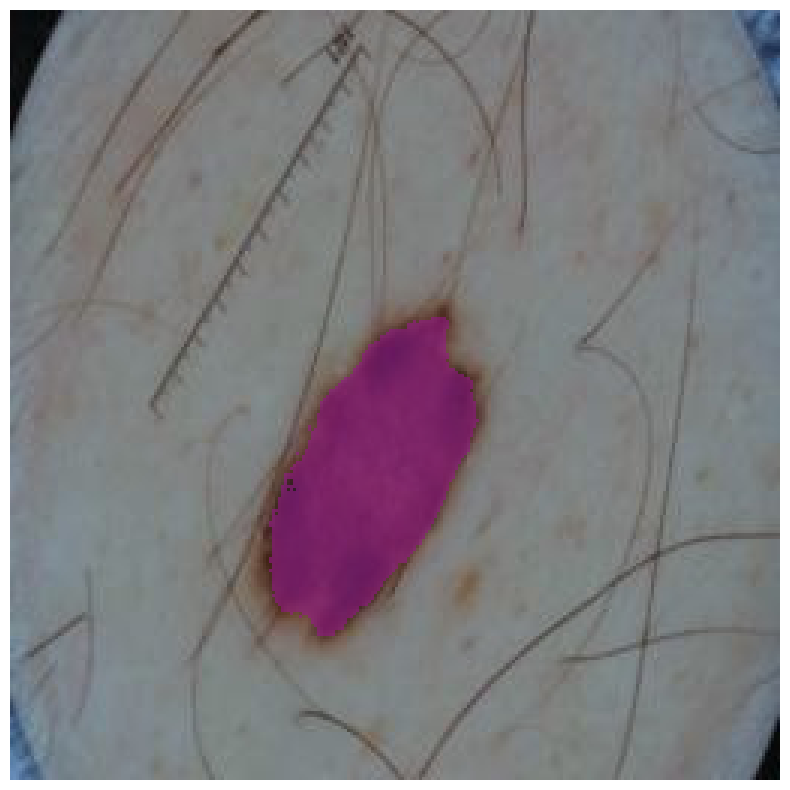

In [29]:

input_point = np.array([[116, 158]])
input_label = np.array([1])
masks, logits, category_pred = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input = None,
    box = None,
    text= None,
    multimask_output=False,
)
print(category_pred)

plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
for box in input_bbox:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()